In [175]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## tree

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## data optimization

from sklearn.preprocessing import OneHotEncoder



1. Считать данные и провести разведочный анализ (основные описательные статистики и графички)
2. Обучить дерево, для предсказания целевой переменной - переменная с именем num

In [356]:
df = pd.DataFrame(pd.read_csv('HeartDiseaseData.csv', header=0))
df.set_index('Unnamed: 0', inplace = True)
df.head()


,ID,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num,Place
Unnamed: 0,,,,,,,,,,,,,
1,1,28,male,atypical angina,130.0,132.0,False,showing probable or definite left ventricular ...,185.0,no,0.0,0,Hungary
2,2,29,male,atypical angina,120.0,243.0,False,normal,160.0,no,0.0,0,Hungary
3,3,29,male,atypical angina,140.0,NaN,False,normal,170.0,no,0.0,0,Hungary
4,4,30,female,typical angina,170.0,237.0,False,having ST-T wave abnormality (T wave inversion...,170.0,no,0.0,0,Hungary
5,5,31,female,atypical angina,100.0,219.0,False,having ST-T wave abnormality (T wave inversion...,150.0,no,0.0,0,Hungary


In [357]:
df.dtypes

ID            int64
Age           int64
Sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
num           int64
Place        object
dtype: object

In [358]:
df.describe()

,ID,Age,trestbps,chol,thalach,oldpeak,num
count,457.000000,457.000000,424.000000,431.000000,424.000000,421.000000,457.000000
mean,229.000000,50.962801,131.488208,200.048724,134.910377,0.622090,0.459519
std,132.068795,9.219588,18.829454,113.463794,24.251177,0.922115,0.498905
min,1.000000,28.000000,80.000000,0.000000,69.000000,-2.600000,0.000000
25%,115.000000,45.000000,120.000000,171.000000,118.000000,0.000000,0.000000
50%,229.000000,52.000000,130.000000,220.000000,135.000000,0.000000,0.000000
75%,343.000000,57.000000,140.000000,269.500000,150.000000,1.000000,1.000000
max,457.000000,75.000000,200.000000,603.000000,190.000000,5.000000,1.000000


In [414]:
plt.rcParams['figure.figsize'] = [7,7]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f65899c2c18>,
      dtype=object)

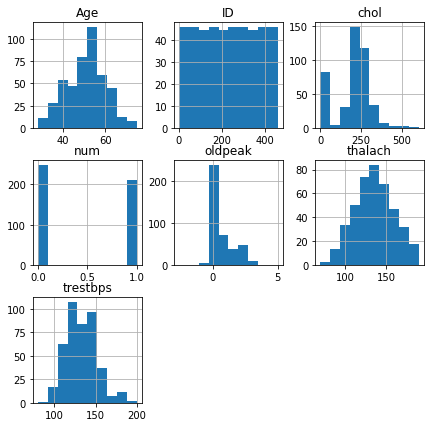

In [360]:
df.hist()

По графикам видно, что данные в порядке: нет отрицательных значений, переменная которую мы будем предсказывать - бинарная, распределение величин более-менее нормальное. 


In [366]:
df.columns[df.isna().any()].tolist()

['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak']

Это колонки с NA

In [367]:
df[df.columns[df.isna().any()].tolist()].dtypes

trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
dtype: object

In [181]:
df = df.fillna(df.mean())
df[df.columns[df.isna().any()].tolist()].dtypes

restecg    object
exang      object
dtype: object

In [182]:
df['restecg'].fillna(df['restecg'].value_counts().index[0], inplace=True)
df['exang'].fillna(df['exang'].value_counts().index[0], inplace=True)
df[df.columns[df.isna().any()].tolist()].dtypes

Series([], dtype: object)

Все колонки с NA были заменены на среднее значение по колонке.

In [183]:
X = df.drop('num', axis=1)
y = df['num']
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.25)


Данные типа "строка" были факторизованы 

In [ ]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'max_features' : range(10, 200, 2), 'min_samples_split': range(2, 20, 1), 'max_depth': range(1, 8, 1),'min_samples_leaf': range(1, 10, 1)},
                  scoring=scoring, refit='AUC', return_train_score=True, cv = 5)

clf = gs.fit(X_train, y_train)

в clf содержится набор моделей, обученых на X_train, y_train

In [316]:
results = clf.cv_results_
best_model = clf.best_estimator_
predicted = best_model.predict(X_test)
best_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=194, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=19,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

Таким образом, были найдены параметры для лучшего дерева. 

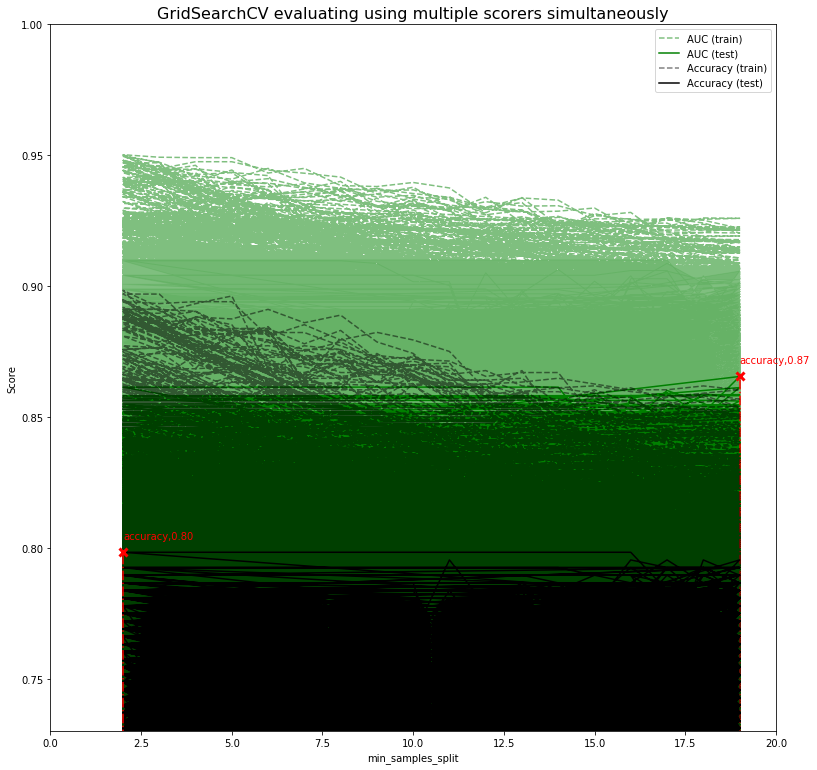

In [413]:
#gs.fit(X, y)
results = clf.cv_results_


plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 20)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), [ 'g', 'k',]):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.5,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color='r', marker='x', markeredgewidth=3, ms=8)
    # Annotate the best score for that scorer
    ax.annotate("accuracy,%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005), color = 'r')

plt.legend(loc="best")
plt.grid('off')
plt.show()

Здесь могло быть видно как различаются скоры предсказания train и test,но в силу большого количества параметров, которые подавались в gridSearch, можно едва разлиичить 0.80 и 0.87 для тестовой и тренировочной выборки

Теперь надо провести кросс-валидацию, например, loo и StratifiedKFold

Text(0,0.5,'Predictions')

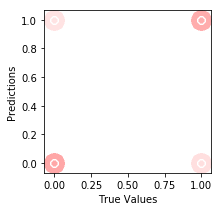

In [401]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.scatter(y_test, best_model.predict(X_test), lw=15, color='r', alpha=.008)
plt.xlabel('True Values')
plt.ylabel('Predictions')


Судя по графику выше, есть какой-то набор значений, когда дерево ошибается, что также следует из скоров  0.80 и 0.87

In [363]:
from scipy import interp

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import LeaveOneOut

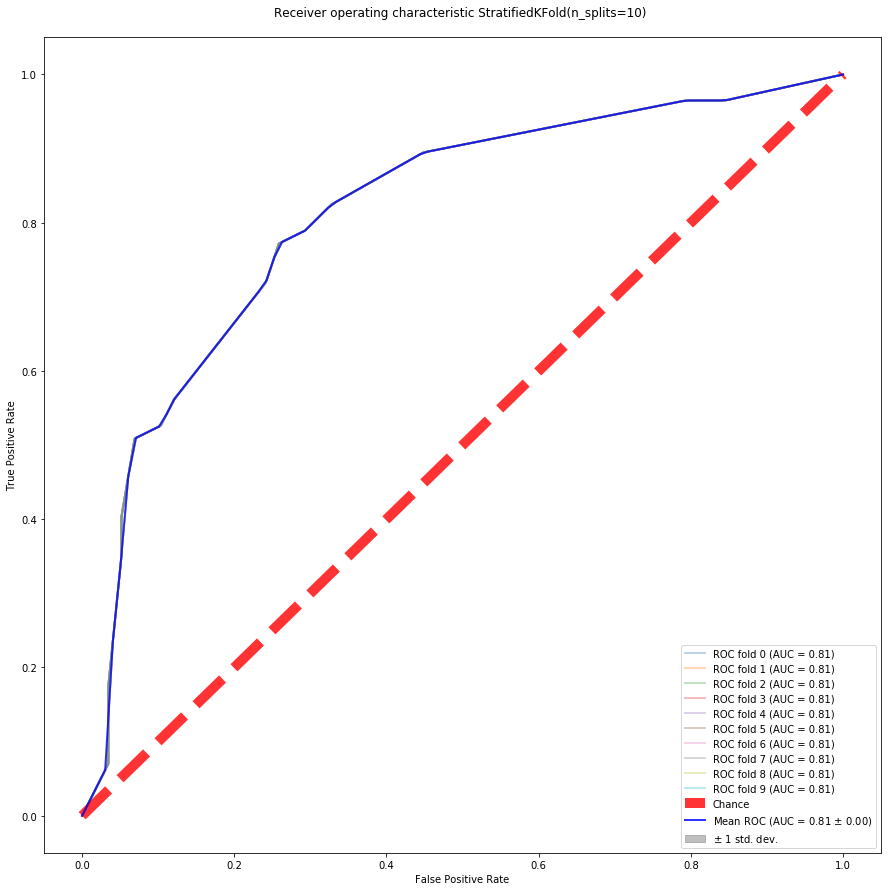

In [422]:
loo = LeaveOneOut()
cv = StratifiedKFold(n_splits=10)
classifier = best_model

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
linewidths = 30
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

dt = best_model
#dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 5)

for train, test in cv.split(X,y):
    predicted = dt.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, predicted[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=10, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic StratifiedKFold(n_splits=10) \n ')
plt.legend(loc="lower right")
plt.show()

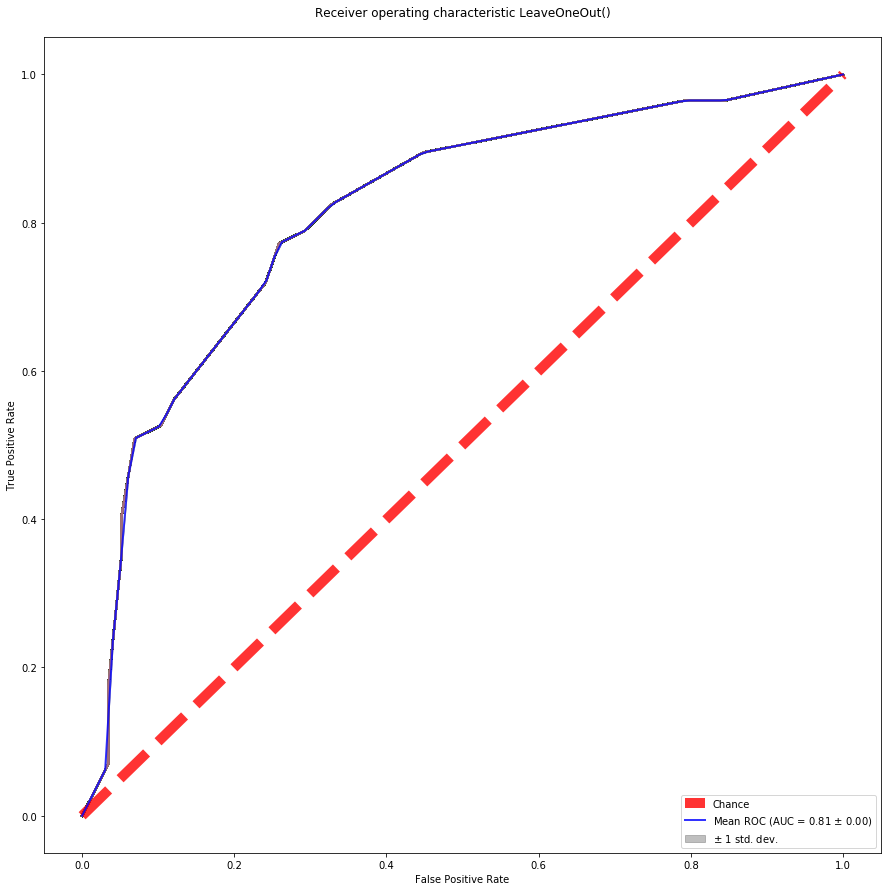

In [420]:
loo = LeaveOneOut()
cv = StratifiedKFold(n_splits=10)
classifier = best_model

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
linewidths = 30
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

dt = best_model
#dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 5)

for train, test in loo.split(X):
    predicted = dt.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, predicted[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3,label='')
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=10, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic LeaveOneOut()\n ')
plt.legend(loc="lower right")
plt.show()

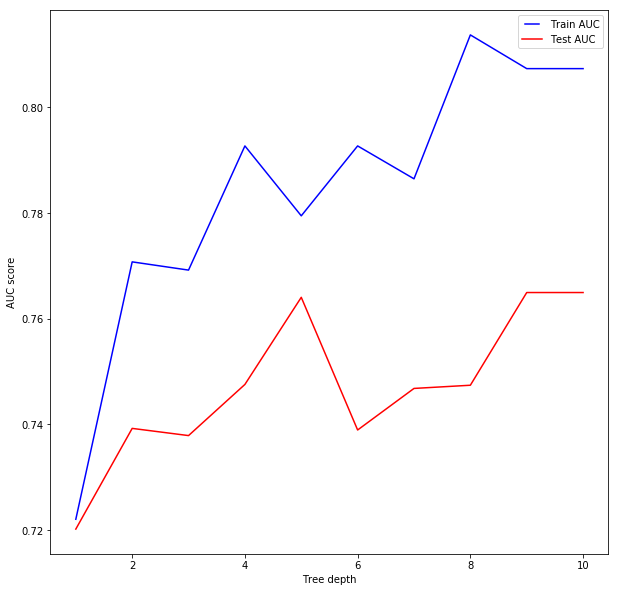

In [411]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
#max_depths = range(2,30,1)

plt.rcParams['figure.figsize'] = [10, 10]
#max_depths = list(range(2, 20))

train_results = []
test_results = []
for max_depth_s in max_depths:

    #dt = DecisionTreeClassifier(max_depth=max_depth)
    dt = DecisionTreeClassifier(max_depth = max_depth_s, max_features= 194 ,min_samples_leaf=7, min_samples_split=19,random_state=42)
    dt = dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)

    y_pred = dt.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Судя по AUC и ROC, дерево можно обучить лучше, потому что достаточно большой процент неверных решений. 